### Machine Learning

- Maria Zazpe Quintana

- Alba Rodríguez Berenguel

En este notebook vamos a realizar un modelo Random Forest. Los pasos que vamos a seguir son:

1. Importación de librerías, funciones y datos.
2. Creación del modelo.
3. Entrenamiento del modelo.
4. Predicciones y evaluación.
5. Exportación del modelo.

## 1. Importación de librerías, funciones y datos. 

In [1]:
# # Import libraries.
import pandas as pd
import matplotlib.pyplot as plt
import pickle 
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to evaluate the model.
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))

In [3]:
# Load data.
X_train_val = pd.read_csv("../data/processed/X_train_val.csv",index_col=0 )
y_train_val = pd.read_csv("../data/processed/y_train_val.csv",index_col=0 )

x_val = pd.read_csv("../data/processed/X_val.csv",index_col=0 )
y_val = pd.read_csv("../data/processed/y_val.csv",index_col=0 )

## 2. Creación del modelo.

In [4]:
# Import the preprocessor.
preprocessor = pickle.load(open('../models/preprocessor.pickle', 'rb'))

#Classifier.
classifier = RandomForestClassifier(random_state = 12345, n_jobs = -1, class_weight = 'balanced')

In [5]:
random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)   
])

## 3. Entrenamiento del modelo.

In [6]:
random_forest.fit(X_train_val, y_train_val)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['delivery',
                                                   'outdoor_seating',
                                                   'credit_cards',
                                                   'bike_parking',
                                                   'price_range', 'take_out',
                                                   'wifi', 'alcohol', 'caters',
                                                   'wheelchair_accessible',
                                                   'good_for_kids', 'attire',
                                                   'reservations',
                                                   'table_service',
                                                   'good_for_groups', 'tv',
                                                   'noise_level']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['useful', 'funny',
                                                   'cool'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=12345))])

## 4. Predicciones y evaluación.

In [7]:
# Predictions of target value for the validation set.
pred = random_forest.predict(x_val)

# Predictions of probabilities of the target value for the validation set.
pred_proba = random_forest.predict_proba(x_val)

### Precision, Recall, F1 y accuracy.

In [8]:
# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_val, pred)

Accuracy of the model: 0.6545102239170943

Classification report: 
              precision    recall  f1-score   support

           0       0.41      0.54      0.46     45127
           1       0.80      0.70      0.74    116406

    accuracy                           0.65    161533
   macro avg       0.60      0.62      0.60    161533
weighted avg       0.69      0.65      0.67    161533




- **Support** nos dice los datos reales que tenemos, 43264 que son 0 y 110766 que son 1.


- La **precisión** se calcula con las columnas de la matriz de confusión y es 0.41 para los casos 0 y 0.79 para los casos 1. Identifica más 1, pero falla muchos 0.


- El **recall** se calcula con las filas de la matriz de confusión, la predicción no es muy buena porque solo acierta el 0.54 de casos 0 y 0.69 de casos 1.


- El **f1** es la combinación de estas dos medidas y el resultado es similar. Identifica 0.74 de puntuación alta y 0.46 puntuación baja.


- El **accuracy** se calcula con la matriz de confusión y es 0.65, es decir, que el modelo predice correctamente el 65% de los casos, no es demasiado elevado, el modelo falla bastante.

### Matriz de confusión.

Confusion matrix, without normalization
[[24241 20886]
 [34922 81484]]
Normalized confusion matrix
[[0.53717287 0.46282713]
 [0.30000172 0.69999828]]


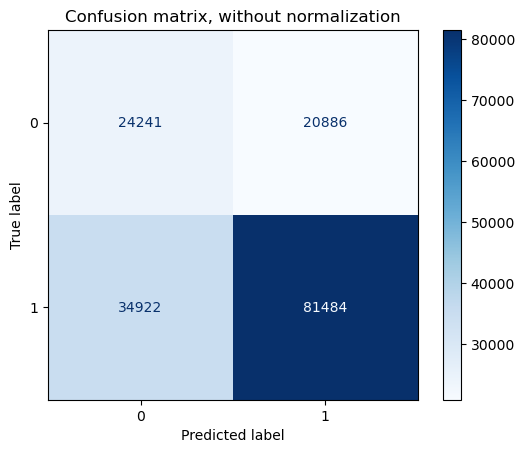

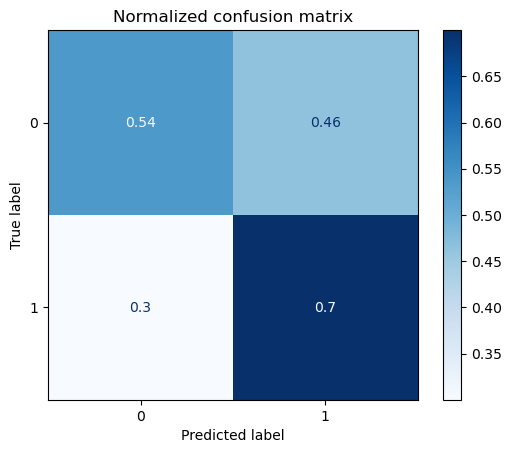

In [9]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(random_forest, x_val, y_val,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

La matriz de confusión nos muestra que en el caso de los 0, el modelo se equivoca en 23319 casos que los predice como 1 y 19945 que son 0 y sí acierta. Por otro lado, predice 33986 que son 1, como 0, y 76780 1 correctamente.

### Curva ROC. 

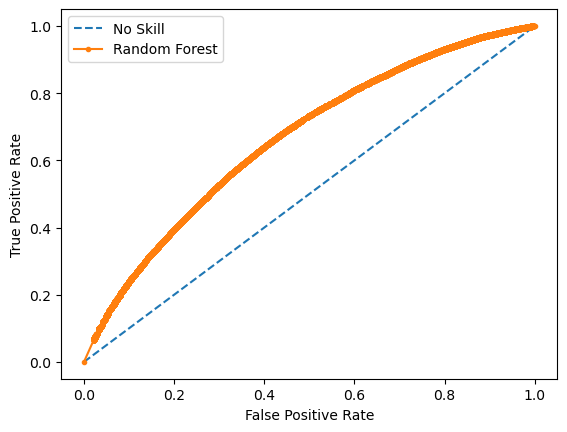

In [10]:
# Keep probabilities for the positive outcome only
yhat = pred_proba[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

La clave de la curva ROC es que cuanto más cerca esté de la esquina superior izquierda de nuestro gráfico y cuanta más área haya debajo de la curva, mejor será el modelo. En este caso se aprecia que la curva está muy alejada de representar un buen modelo, ya que su predicción no es muy alta.

### Curva Lift.

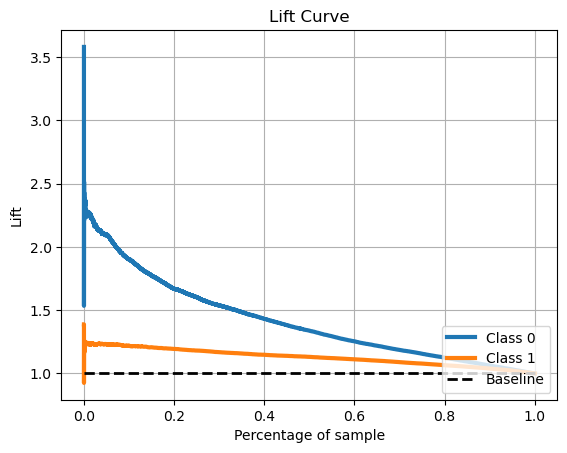

In [11]:
skplt.metrics.plot_lift_curve(y_val, pred_proba)
plt.show()

El modelo comienza prediciendo mejor la clase 0, pero rapidamente disminuye, la clase 1 más o menos se mantiene la predicción para todos los porcentajes de muestra.

### Curva de ganancia.

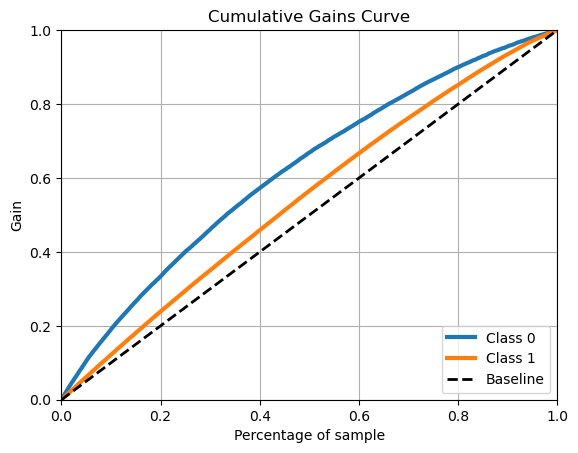

In [12]:
skplt.metrics.plot_cumulative_gain(y_val, pred_proba)
plt.show()

La ganancia de la clase 0 es superior a la de la clase 1, tomando por ejemplo el 20% de la muestra, se detectaría sobre el 25% de la clase 1 y el 30% de la clase 0. Esta probabilidad aumenta a media que se incrementa el tamaño de la muestra.

## 5. Exportación del modelo.

In [13]:
with open('../models/random_forest.pickle', 'wb') as f:
    pickle.dump(random_forest, f)

In [14]:
# To avoid the fit again.
with open('../models/random_forest.pickle', 'rb') as f:
    random_forest = pickle.load(f)